In [1]:
# Import packages
from skimage.transform import rescale
from keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import tensorflow as tf
import glob

In [2]:
# loading images 
images = glob.glob('../../GPU testings/data/lfw/**/*.jpg')

C:\Users\KalburgS\AppData\Local\Temp\ipykernel_50952\1751483802.py:13: FutureWarning: `multichannel` is a deprecated argument name for `rescale`. It will be removed in version 1.0. Please use `channel_axis` instead.
  downsized_image = rescale(rescale(image_resized, 0.25,multichannel=True), 4.0, multichannel=True)


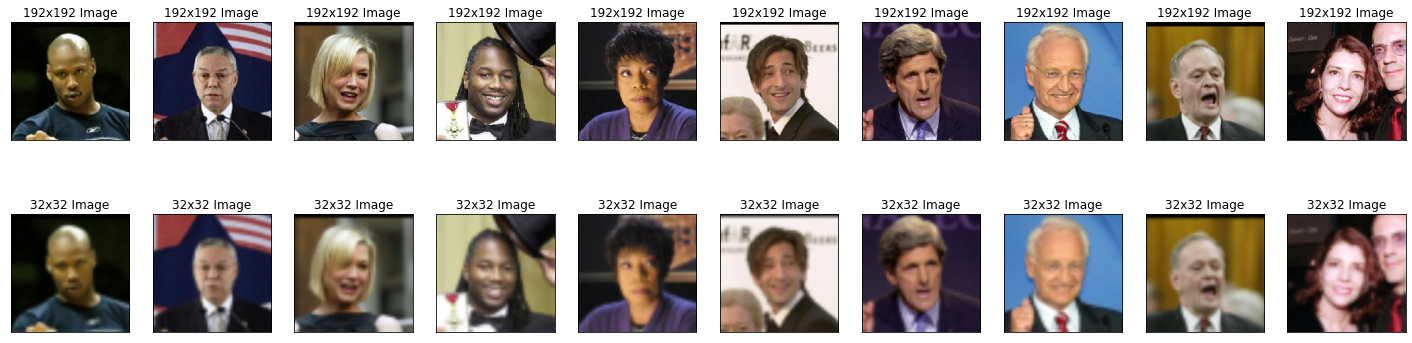

In [3]:
n = 10
plt.figure(figsize= (25,10))
for i in range(n):
  ax = plt.subplot(3, n, i+1)
  index = np.random.randint(0, len(images))
  img = image.load_img(str(images[index]), target_size=(192,192,3))
  image_resized = image.img_to_array(img)/255.
  plt.imshow(image_resized)
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
  plt.title('192x192 Image')
  ax = plt.subplot(3, n, i+1+n)
  downsized_image = rescale(rescale(image_resized, 0.25,multichannel=True), 4.0, multichannel=True)
  plt.imshow(downsized_image)
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
  plt.title('32x32 Image')
plt.show()

In [4]:
# Building a Model
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Dropout, Conv2DTranspose, UpSampling2D, add
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, LearningRateScheduler

# Building the Encoder
input_img = Input(shape=(192, 192, 3))
l1 = Conv2D(32, (3, 3), padding='same', activation='relu',
            activity_regularizer=regularizers.l1(10e-10))(input_img)
l2 = Conv2D(32, (3, 3), padding='same', activation='relu',
            activity_regularizer=regularizers.l1(10e-10))(l1)

l3 = MaxPooling2D(padding='same')(l2)
l3 = Dropout(0.2)(l3)
l4 = Conv2D(64, (3, 3),  padding='same', activation='relu',
            activity_regularizer=regularizers.l1(10e-10))(l3)
l5 = Conv2D(64, (3, 3), padding='same', activation='relu',
            activity_regularizer=regularizers.l1(10e-10))(l4)

l6 = MaxPooling2D(padding='same')(l5)
l6 = Dropout(0.2)(l6)
l7 = Conv2D(128, (3, 3), padding='same', activation='relu',
            activity_regularizer=regularizers.l1(10e-10))(l6)

l8 = MaxPooling2D(padding='same')(l7)
l8 = Dropout(0.2)(l8)
l9 = Conv2D(256, (3, 3), padding='same', activation='relu',
            activity_regularizer=regularizers.l1(10e-10))(l8)

In [5]:
# Building the Decoder
l10 = UpSampling2D()(l9)
l10 = Dropout(0.2)(l10)
l11 = Conv2D(128, (3, 3), padding='same', activation='relu',
            activity_regularizer=regularizers.l1(10e-10))(l10)

l12 = add([l7, l11])
l13 = UpSampling2D()(l12)
l13 = Dropout(0.2)(l13)
l14 = Conv2D(64, (3, 3), padding='same', activation='relu',
            activity_regularizer=regularizers.l1(10e-10))(l13)
l15 = Conv2D(64, (3, 3), padding='same', activation='relu',
             activity_regularizer=regularizers.l1(10e-10))(l14)

l16 = add([l5, l14])
l17 = UpSampling2D()(l16)
l17 = Dropout(0.2)(l17)
l18 = Conv2D(32, (3, 3), padding='same', activation='relu',
             activity_regularizer=regularizers.l1(10e-10))(l17)
l19 = Conv2D(32, (3, 3), padding='same', activation='relu',
             activity_regularizer=regularizers.l1(10e-10))(l18)

l20 = add([l18, l2])


In [6]:

# chan = 3, for RGB
decoded = Conv2D(3, (3, 3), padding='same', activation='relu',
                 activity_regularizer=regularizers.l1(10e-10))(l20)

# Create our network
autoencoder = Model(input_img, decoded)

autoencoder.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])
autoencoder.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 192, 192, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 192, 192, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 192, 192, 32) 9248        conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 96, 96, 32)   0           conv2d_1[0][0]                   
______________________________________________________________________________________________

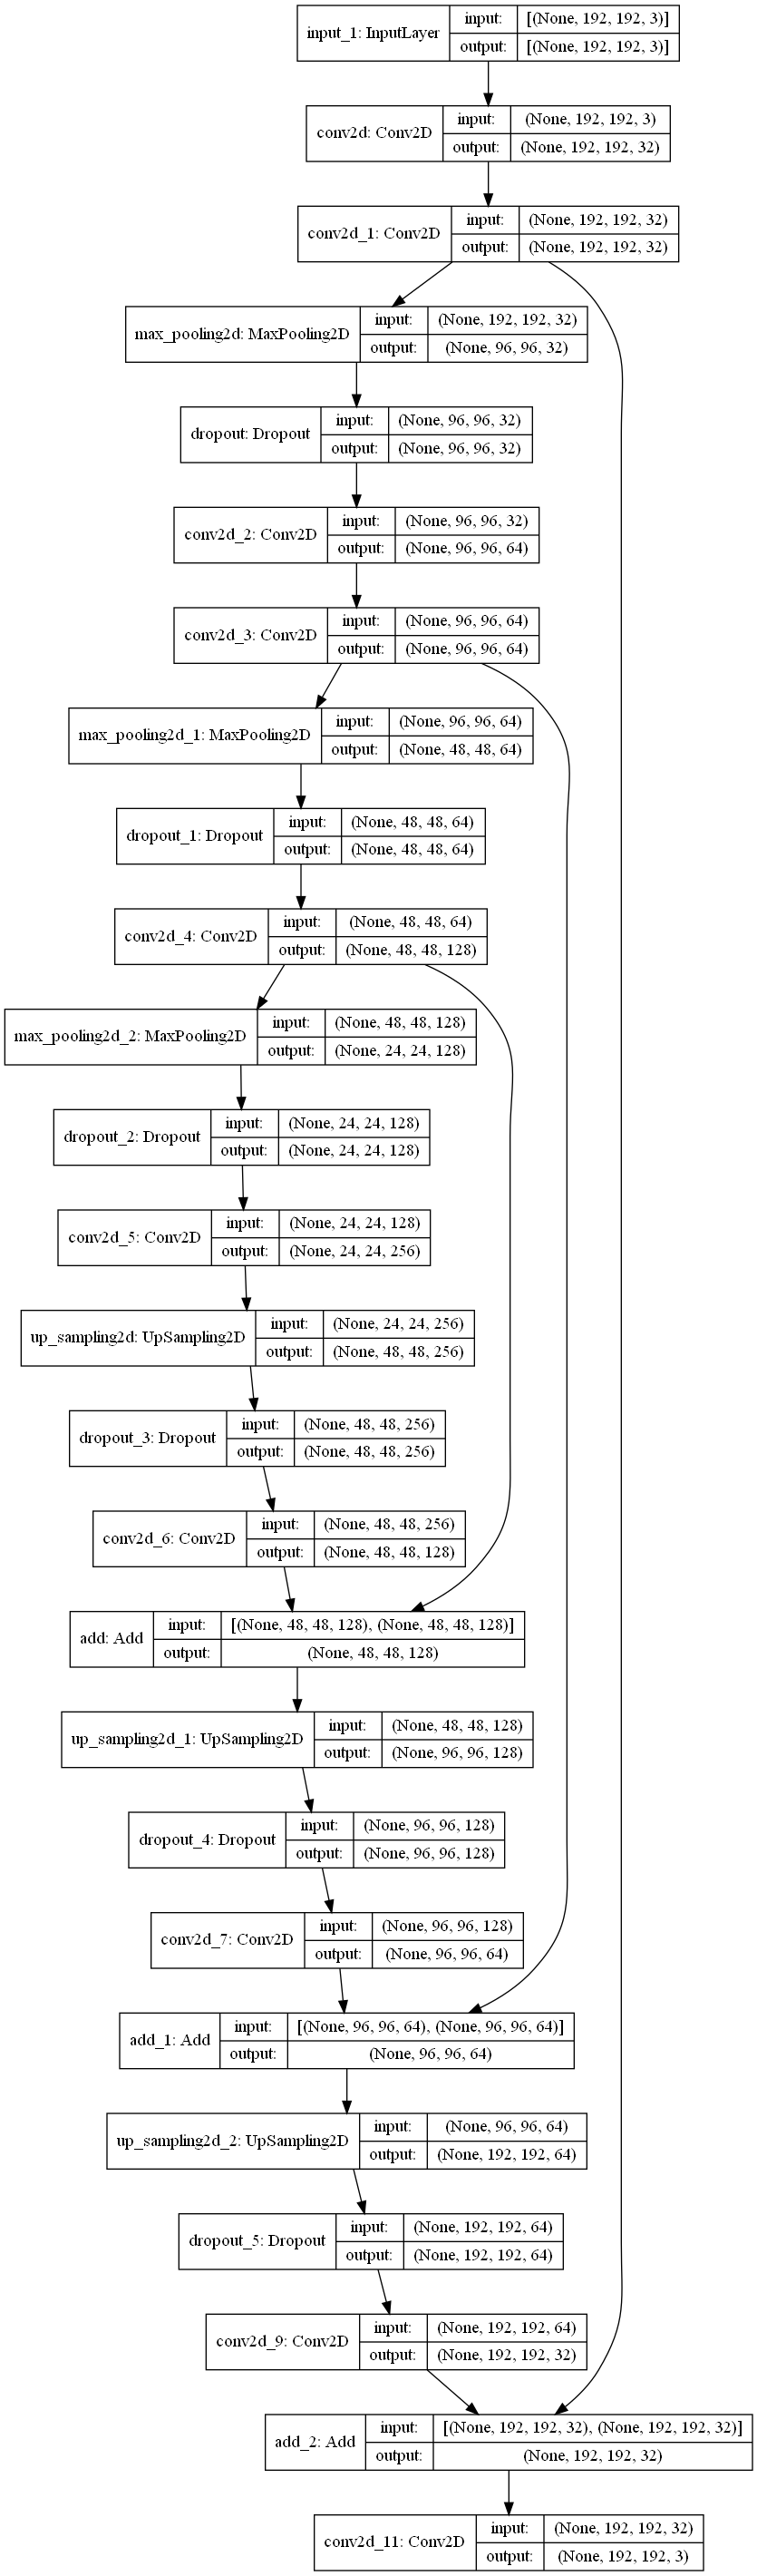

In [7]:
tf.keras.utils.plot_model(
    autoencoder,
    # to_file="model.png",
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=96,
    layer_range=None,
    # show_layer_activations=False,
)

In [8]:
# Defining callback functions
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=8,
                             min_lr=0.00001, mode='auto', cooldown=2)
early_stop = EarlyStopping(monitor='val_loss', patience=10)
model_checkpoint =  ModelCheckpoint('ISR_AutoEncoder.h5', save_best_only = True, monitor="val_accuracy")
callbacks = [reduce_lr, early_stop, model_checkpoint]

In [9]:
# Training the model
x_train_n = []
x_train_down = []
print('Loading Train Data.....')
progress = tqdm(total = 10000, position = 0)
for x in range(10000):
  try:
      index = np.random.randint(0, len(images))
      img = image.load_img(str(images[index]), target_size=(192,192,3))
      image_resized = image.img_to_array(img)/255.
      x_train_n.append(image_resized)
      x_train_down.append(rescale(rescale(image_resized, 0.25,
                                          multichannel=True),
                                  4.0, multichannel=True))
      del images[index]
      progress.update(1)
  except:
      del images[index]
      progress.update(1)
      print("Error loading image")

Loading Train Data.....


  0%|          | 0/10000 [00:00<?, ?it/s]C:\Users\KalburgS\AppData\Local\Temp\ipykernel_50952\1269921706.py:12: FutureWarning: `multichannel` is a deprecated argument name for `rescale`. It will be removed in version 1.0. Please use `channel_axis` instead.
  x_train_down.append(rescale(rescale(image_resized, 0.25,
100%|█████████▉| 9991/10000 [01:44<00:00, 98.95it/s] 

In [10]:
print("Length: ", len(x_train_n))
print('Training the model....')
history_ae = autoencoder.fit(np.array(x_train_down), np.array(x_train_n),
              epochs=100,
              batch_size=32,
              shuffle=True,
              validation_split=0.15,
              callbacks=callbacks)

Length:  10000
Training the model....
Epoch 1/100


100%|██████████| 10000/10000 [02:00<00:00, 98.95it/s]

266/266 [==============================] - 100s 292ms/step - loss: 0.0143 - accuracy: 0.7932 - val_loss: 0.0024 - val_accuracy: 0.8829
Epoch 2/100


d:\Users\KalburgS\Anaconda3\envs\pygames\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


266/266 [==============================] - 74s 277ms/step - loss: 0.0023 - accuracy: 0.8924 - val_loss: 0.0020 - val_accuracy: 0.9096
Epoch 3/100
266/266 [==============================] - 74s 277ms/step - loss: 0.0021 - accuracy: 0.9034 - val_loss: 0.0018 - val_accuracy: 0.9126
Epoch 4/100
266/266 [==============================] - 298s 1s/step - loss: 0.0019 - accuracy: 0.9072 - val_loss: 0.0017 - val_accuracy: 0.9169
Epoch 5/100
266/266 [==============================] - 325s 1s/step - loss: 0.0018 - accuracy: 0.9091 - val_loss: 0.0017 - val_accuracy: 0.9074
Epoch 6/100
266/266 [==============================] - 322s 1s/step - loss: 0.0017 - accuracy: 0.9136 - val_loss: 0.0016 - val_accuracy: 0.9156
Epoch 7/100
266/266 [==============================] - 321s 1s/step - loss: 0.0017 - accuracy: 0.9148 - val_loss: 0.0015 - val_accuracy: 0.9237
Epoch 8/100
266/266 [==============================] - 323s 1s/step - loss: 0.0016 - accuracy: 0.9146 - val_loss: 0.0015 - val_accuracy: 0.9193


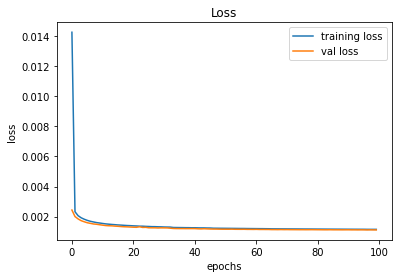

In [11]:
# Plotting graphs for loss
plt.plot(history_ae.history['loss'], label='training loss')
plt.plot(history_ae.history['val_loss'], label='val loss')
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

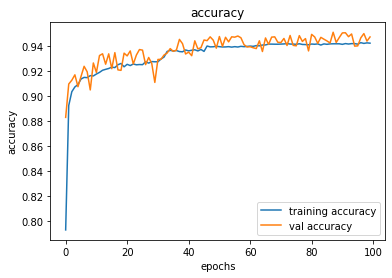

In [12]:
# Plotting graphs for Accuracy
plt.plot(history_ae.history['accuracy'], label='training accuracy')
plt.plot(history_ae.history['val_accuracy'], label='val accuracy')
plt.title('accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

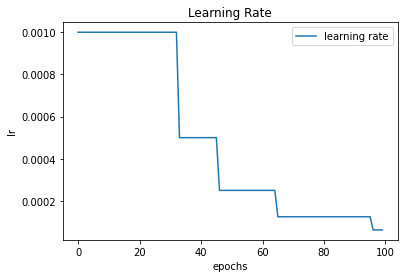

In [13]:
# Plotting graphs for lr
plt.plot(history_ae.history['lr'], label='learning rate')
plt.title('Learning Rate')
plt.xlabel('epochs')
plt.ylabel('lr')
plt.legend()
plt.show()

In [14]:
x_test_n = []
x_test_down = []
progress = tqdm(total= len(images), position=0)
for img in images:
  img = image.load_img(str(img), target_size=(192,192,3))
  image_resized = image.img_to_array(img)/255.
  x_test_n.append(image_resized)
  x_test_down.append(rescale(rescale(image_resized, 0.25,
                                      multichannel=True),
                              4.0, multichannel=True))
  progress.update(1)

100%|██████████| 10000/10000 [3:51:58<00:00,  1.39s/it]
C:\Users\KalburgS\AppData\Local\Temp\ipykernel_50952\4090388254.py:8: FutureWarning: `multichannel` is a deprecated argument name for `rescale`. It will be removed in version 1.0. Please use `channel_axis` instead.
  x_test_down.append(rescale(rescale(image_resized, 0.25,
100%|█████████▉| 3227/3233 [00:33<00:00, 91.26it/s]

In [15]:
print('Loss and Accuracy on test data....')
results = autoencoder.evaluate(np.array(x_test_down), np.array(x_test_n))

Loss and Accuracy on test data....
102/102 [==============================] - 14s 139ms/step - loss: 0.0011 - accuracy: 0.9471


In [16]:
predictions = autoencoder.predict(np.array(x_test_down))

100%|██████████| 3233/3233 [00:53<00:00, 91.26it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


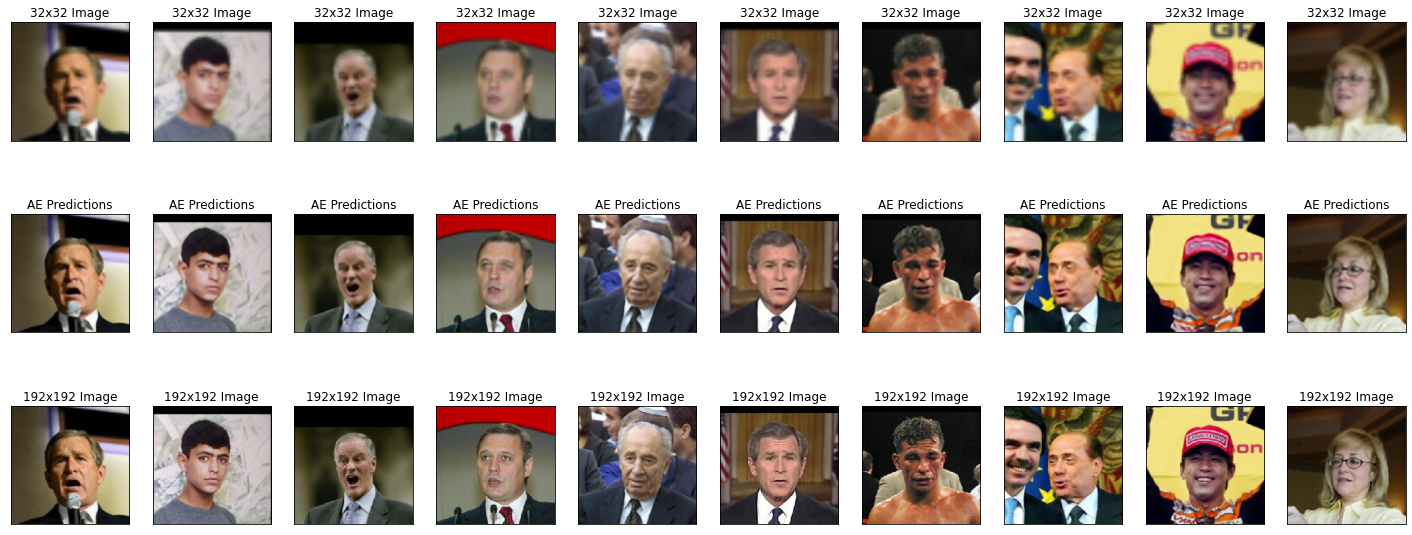

In [17]:
n = 10
plt.figure(figsize= (25,10))
for i in range(n):
  ax = plt.subplot(3, n, i+1)
  index = np.random.randint(0, len(x_test_down))
  plt.imshow(x_test_down[index])
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
  plt.title('32x32 Image')
  ax = plt.subplot(3, n, i+1+n)
  plt.imshow(predictions[index])
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
  plt.title('AE Predictions')
  ax = plt.subplot(3, n, i+11+n)
  plt.imshow(x_test_n[index])
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
  plt.title('192x192 Image')
plt.show()

In [18]:
# Represeting Model as JSON String
autoencoder_json = autoencoder.to_json()
with open('ISR_model.json', 'w') as json_file:
  json_file.write(autoencoder_json)